# Introduction to Deep Learning

### Hands-on 2a: MNIST
Filippo Vicentini and Giuseppe Carleo

The objective of this hands-on is to write and optimise an image-classifier that identifies handwritten digits.

We will use for this the MNIST dataset

![title](images/mnist.png)

In [79]:
# Requirements
#!pip install tensorflow_datasets flax jax optax

In [2]:
# Utility functions (don't worry. you don't need to understand this one)

from matplotlib import pyplot as plt

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[..., 0], cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    show_img(img, axs[i // n][i % n], title)

In [3]:
# Import 
import jax
import jax.numpy as jnp

import numpy as np

## 1 - Setting up the dataset
First of all, we need to download the dataset.

The MNIST dataset is a standard dataset composed of several 28x28 black/white images representing numbers, and a label corresponding to the number that is represented there.

In [4]:
# We use Tensorflow datasets to download and import data in a simple numpy-tensor format
# It's just handy. You could use anything else.

import tensorflow_datasets as tfds

# Specify the dataset we are interested in
ds_builder = tfds.builder('mnist')
# Download the data
ds_builder.download_and_prepare()
# Get the whole dataset's train set
train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))

train_ds['image'] = jnp.float32(train_ds['image']) / 255.
test_ds['image'] = jnp.float32(test_ds['image']) / 255.

# convert to bool
train_ds['image'] = train_ds['image']>=0.5
test_ds['image'] = test_ds['image']>=0.5

The dataset is split into two sub-sets: the training dataset that we will use to 'train' our model, and the 'test' dataset, which the model *never sees* during training, but that we use to check that the model performs well.

This is to verify that the model does not simply learn _by heart_ the images in the training dataset, but that it actually _learns_ to generalize and works correctly with images that he did not see before.

We can inspect the shape of the training dataset:

In [5]:
print("dataset keys:", train_ds.keys())
print(f"The training dataset has shape: {train_ds['image'].shape} and dtype {train_ds['image'].dtype}")
print(f"The test     dataset has shape: {test_ds['image'].shape} and dtype {train_ds['image'].dtype}")
print("")
print(f"The training labels have shape: {train_ds['label'].shape} and dtype {train_ds['label'].dtype}")
print(f"The test     labels have shape: {test_ds['label'].shape} and dtype {test_ds['label'].dtype}")

dataset keys: dict_keys(['image', 'label'])
The training dataset has shape: (60000, 28, 28, 1) and dtype bool
The test     dataset has shape: (10000, 28, 28, 1) and dtype bool

The training labels have shape: (60000,) and dtype int64
The test     labels have shape: (10000,) and dtype int64


We can visualize it to understand it a bit more, using an utility function

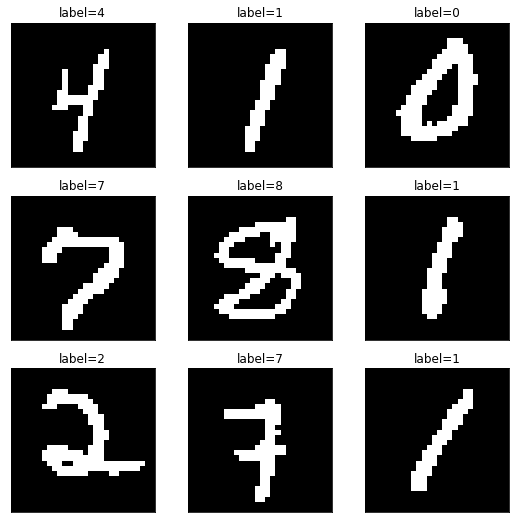

In [6]:
show_img_grid(
    [train_ds['image'][idx] for idx in range(9)],
    [f'label={train_ds["label"][idx]}' for idx in range(9)],
)

We have seen that the data is stored in uint8 (an *unsigned* 8-bit integer which can take values from 0 to 255 ).

However it is often preferable when working with Neural Networks to work with floating-point values with values around 0 and variance approximately 1. The reasons are 2:

 - modern CPUs (and to an extent GPUs) are often faster at working with batches (blocks) of floating-point numbers rather than integers [caveats apply]
 - Many nonlinear functions used in machine-learning have the nonlinear crossover aroud ~0 or ~1/2, so we want our data to be spread around those values
 - Most research about how to initialize neural-network layers assumes that the input data has mean 0 and variance 1, so to exploit those results we have to rescale our data

## 2 - The model (Neural Network)

We want now to define the Model.
We will use Flax to do that.

We want our network to return a probability distribution for the input to correspond to one of several output labels.

e.g: if $x$ is an image, then $f : \mathbb{R}^{28\times 28}\rightarrow \mathbb{R}^{10}$ and $f^{(i)}(x)$ is the probability that the image $x$ represents a $i\in[0,9]$

To make the output of the network a probability distribution, we can use a softmax function, defined as

$$
\sigma_i(x) = \frac{e^{x_i}}{\sum_i^K e^{x_i} }  \text{   for  } i\in [1,K] \text{ and } x\in\mathbb{R}^K
$$

We want to use a Feedforward network with 2 Dense Layers, relu-nonlinearity and output softmax using Flax.


In [234]:
import jax
import jax.numpy as jnp

# We import flax.linen as nn
# The reason is that flax.nn is old and deprecated and will be removed one day
import flax.linen as nn

In [268]:
# A Flax model must be a class sub-classing nn.Module
class Model(nn.Module):
    
    # We can have some attributes of the Model. 
    # Those are considered compile-time constants and must be hashable
    # They are useful to define some variables that might be changed often
    hidden_width : int = 1024
    """
    The width of the hidden dense layers in the neural network.
    """
    n_outputs : int = 10
    """
    Number of output classes for the classifier 
    """
    
    # The body of the model must be defined using the `@nn.compact` decorator.
    # Just think of it as boilerplate, and if you are curious, check out
    # Flax documentation
    @nn.compact
    def __call__(self, x):
        """
        This function should evaluate the result of the model for an input image
        x or a batch of images x.
        
        x has shape (28,28,1) or (N, 28, 28, 1)
        """
        # we first ensure a single image is a 4-tensor
        if x.ndim == 3:
            x = x.reshape((1, ) + x.shape)
            
        # We first "vectorize" the image
        x = x.reshape((x.shape[0], -1))
        
        # First dense layer
        x = nn.Dense(features=self.hidden_width)(x)
        # First nonlinear activation function
        x = nn.relu(x)
        #x = nn.Dense(features=self.hidden_width)(x)
        #x = nn.relu(x)
        x = nn.Dense(features=self.n_outputs)(x)
        x = nn.log_softmax(x)
        return x

Let's initialize the model:
 
 - We need a seed for the RNG that generates the initial weights
 - We need a sample input

In [269]:
seed = 123

model = Model(hidden_width = 1024, n_outputs=10)

key = jax.random.PRNGKey(seed)
sample_input = jnp.ones([1, 28, 28, 1])

pars = model.init(key, sample_input)

we can inspect the parameters `pars`:

In [270]:
pars

FrozenDict({
    params: {
        Dense_0: {
            kernel: DeviceArray([[ 0.06272361, -0.04523007,  0.04455307, ...,  0.0401537 ,
                           0.04866179, -0.05893217],
                         [ 0.03216646, -0.05071622,  0.01560513, ..., -0.00933223,
                          -0.00218637,  0.01502309],
                         [ 0.06411006, -0.0392851 , -0.02909053, ...,  0.01578827,
                          -0.02766293,  0.0776424 ],
                         ...,
                         [ 0.01668577,  0.00019089,  0.02212064, ..., -0.01364938,
                          -0.00778654, -0.01584569],
                         [-0.01295255,  0.00911052,  0.00867082, ...,  0.02317737,
                          -0.01509016, -0.01241465],
                         [ 0.01655648,  0.04822065,  0.01358693, ..., -0.0194821 ,
                          -0.00854595,  0.01909487]], dtype=float32),
            bias: DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
      

In [271]:
# sample application:
jnp.exp(model.apply(pars, jnp.ones([1, 28, 28, 1])))

DeviceArray([[0.07704171, 0.08986449, 0.07054991, 0.04636909, 0.30741608,
              0.064256  , 0.10086796, 0.06952595, 0.10017835, 0.07393045]],            dtype=float32)

## 3 - Writing the loss function

We now want to take as a loss function the distance between the _predicted_ probability given by the model $q_W^{(i)}(x)$ and the actualy probabilith $p^{(i)}(x)$.

The actual probability is a delta function: it is zero for every label except for the correct one, for which it is 1.

To perform this, we can use one-hot encoding, which takes an integer value in $i\in[0..K]$ and returns a vector in $R^K$ where only the i-th component is 1 and the other are zero: $v_j = \delta_{i,j}$.

See the examples below:

In [272]:
for i in range(5):
    print(f"{i} becomes: {jax.nn.one_hot(i, 5)}")

0 becomes: [1. 0. 0. 0. 0.]
1 becomes: [0. 1. 0. 0. 0.]
2 becomes: [0. 0. 1. 0. 0.]
3 becomes: [0. 0. 0. 1. 0.]
4 becomes: [0. 0. 0. 0. 1.]


For the loss function, i'll draw from my vast knowledge of loss functions (aka: [here](https://optax.readthedocs.io/en/latest/api.html)) and choose `optax.softmax_cross_entropy`

`?optax.softmax_cross_entropy`
> Computes the softmax cross entropy between sets of logits and labels.
>
>Measures the probability error in discrete classification tasks in which
>the classes are mutually exclusive (each entry is in exactly one class).
>For example, each CIFAR-10 image is labeled with one and only one label:
>an image can be a dog or a truck, but not both.
>
>References:
> [Goodfellow et al, 2016](http://www.deeplearningbook.org/contents/prob.html)
>
>Args:
>
>  logits: unnormalized log probabilities.
>
>  labels: a valid probability distribution (non-negative, sum to 1), e.g a
>    one hot encoding of which class is the correct one for each input.


In [273]:
# The loss function that we will use
def cross_entropy(*, logits, labels):
    one_hot_labels = jax.nn.one_hot(labels, num_classes=10)
    return -jnp.mean(jnp.sum(one_hot_labels * logits, axis=-1))

In [274]:
# Our cost function that we will be optimising
def loss_fn(params, images, labels):
    # compute the output of the model
    logits = model.apply({'params': params}, images)
    return cross_entropy(logits=logits, labels=labels)

# An utility function to compute some metrics during the training
def compute_metrics(*, logits, labels):
    loss = cross_entropy(logits=logits, labels=labels)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    metrics = {
      'loss': loss,
      'accuracy': accuracy,
    }
    return metrics

We then need a function to keep the training state in memory

In [275]:
from flax.training import train_state  # Useful dataclass to keep train state

def create_train_state(rng, learning_rate, momentum):
    """Creates initial `TrainState`."""
    params = model.init(rng, jnp.ones([1, 28, 28, 1]))['params']
    tx = optax.sgd(learning_rate, momentum)
    return train_state.TrainState.create(
        apply_fn=model.apply, params=params, tx=tx)


In [276]:
from functools import partial

@jax.jit
def train_step(state, batch):
    """Train for a single step."""
    _loss_fn = partial(loss_fn, images=batch['image'], labels=batch['label'])
    
    grad_fn = jax.value_and_grad(_loss_fn)
    loss, grads = grad_fn(state.params)
    
    state = state.apply_gradients(grads=grads)
    
    logits = model.apply({'params': state.params}, batch['image'])
    metrics = compute_metrics(logits=logits, labels=batch['label'])
    
    return state, metrics


In [277]:
@jax.jit
def eval_step(params, batch):
  logits = model.apply({'params': params}, batch['image'])
  return compute_metrics(logits=logits, labels=batch['label'])

In [278]:
def train_epoch(state, train_ds, batch_size, epoch, rng, *, max_steps=None):
    """Train for a single epoch."""
    
    # total number of training images
    train_ds_size = len(train_ds['image'])
    
    steps_per_epoch = train_ds_size // batch_size

    # Truncate the number of steps (used to speed up training)
    if max_steps is not None:
        steps_per_epoch = min(steps_per_epoch, max_steps)


    # generate a random permutation of the indices to shuffle the training
    # dataset, and reshape it to a set of batches.
    perms = jax.random.permutation(rng, train_ds_size)
    perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))
    
    # execute the training step for every mini-batch
    batch_metrics = []
    for perm in perms:
        batch = {k: v[perm, ...] for k, v in train_ds.items()}
        state, metrics = train_step(state, batch)
        batch_metrics.append(metrics)

    # compute mean of metrics across each batch in epoch.
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
            for k in batch_metrics_np[0]}

    return state, epoch_metrics_np

def eval_model(params, test_ds):
    """
    evaluate the performance of the model on the test dataset
    """
    metrics = eval_step(params, test_ds)
    metrics = jax.device_get(metrics)
    summary = jax.tree_map(lambda x: x.item(), metrics)
    return summary['loss'], summary['accuracy']

In [279]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)

In [280]:
learning_rate = 0.1
momentum = 0.9

In [281]:
state = create_train_state(init_rng, learning_rate, momentum)

In [282]:
num_epochs = 10
batch_size = 32

In [ ]:
from tqdm import tqdm

metrics = {"test_loss" : [], "test_accuracy": [], "train_loss":[], "train_accuracy":[]}

for epoch in tqdm(range(1, num_epochs + 1)):
    # Use a separate PRNG key to permute image data during shuffling
    rng, input_rng = jax.random.split(rng)
    # Run an optimization step over a training batch
    state, train_metrics = train_epoch(state, train_ds, batch_size, epoch, input_rng)
    # Evaluate on the test set after each training epoch
    test_loss, test_accuracy = eval_model(state.params, test_ds)
    print('train epoch: %d, loss: %.4f, accuracy: %.2f' % (epoch, train_metrics['loss'], train_metrics['accuracy'] * 100))
    print(' test epoch: %d, loss: %.2f, accuracy: %.2f' % (epoch, test_loss, test_accuracy * 100))

    # save data
    metrics["train_loss"].append(train_metrics["loss"])
    metrics["train_accuracy"].append(train_metrics["accuracy"])
    metrics["test_loss"].append(test_loss)
    metrics["test_accuracy"].append(test_accuracy)

    

  0%|                                                                                                                  | 0/10 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt

plt.plot(metrics["train_loss"], label="train")
plt.plot(metrics["test_loss"], label="test")